In [1]:
import logging

import numpy as np
import probtorch
import torch

import bouncing_ball
import bouncing_ball_data
import combinators
import foldable
import importance
import mcmc
import utils

In [2]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt

In [3]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [4]:
## dataset parameters
T = 100 ## sequence length
num_series = 1
dt = 1 ## \delta t
Boundary = 6 ## unit box is amplified by this value, centered at origin
signal_noise_ratio = 0.2 # the noise is multiplied by this param
D = 2
## Model parameters
K =  4## number of hidden states

In [5]:
## generate time series
x0, y0, init_v, init_v_rand_dir = bouncing_ball_data.intialization(T, num_series, Boundary)
final_mus = np.zeros((num_series, K, D))
final_covs = np.zeros((num_series, K, D, D))
STATEs = np.zeros((num_series, T+1, 4))
Disps = np.zeros((num_series, T, D))
As_true = np.zeros((num_series, 4, 4))
As_pred = np.zeros((num_series, K, K))
for s in range(num_series):
    init_state = np.array([x0[s], y0[s], init_v_rand_dir[s, 0], init_v_rand_dir[s, 1]])
    STATEs[s], Disps[s], As_true[s] = bouncing_ball_data.generate_data(T, dt, init_state, Boundary, signal_noise_ratio)

In [6]:
num_particles = (100,)

In [7]:
init_bouncing_ball = bouncing_ball.InitBouncingBall(batch_shape=num_particles)

In [8]:
bouncing_ball_step = bouncing_ball.BouncingBallStep(batch_shape=num_particles)

In [9]:
def proposal_step():
    return bouncing_ball.ProposalStep(batch_shape=num_particles, name='BouncingBallStep')

In [10]:
prior_init_params = {
    'position_0': {
        'loc': torch.zeros(2),
        'scale': torch.ones(2),
    },
    'alpha_0': {
        'concentration': torch.ones(4),
    },
    'alpha_1': {
        'concentration': torch.ones(4),
    },
    'alpha_2': {
        'concentration': torch.ones(4),
    },
    'alpha_3': {
        'concentration': torch.ones(4),
    },
    'alpha_4': {
        'concentration': torch.ones(4),
    },
    'directions': {
        'loc': {
            'loc': torch.ones(2),
            'scale': torch.ones(2),
        },
        'cov': {
            'loc': torch.eye(2).expand(4, 2, 2),
            'scale': torch.ones(4, 2, 2),
        },
    },
}

In [11]:
variational_init_params = {
    'position_0': {
        'loc': torch.zeros(2),
        'scale': torch.ones(2),
    },
    'alpha_0': {
        'concentration': torch.ones(4),
    },
    'alpha_1': {
        'concentration': torch.ones(4),
    },
    'alpha_2': {
        'concentration': torch.ones(4),
    },
    'alpha_3': {
        'concentration': torch.ones(4),
    },
    'alpha_4': {
        'concentration': torch.ones(4),
    },
    'directions': {
        'loc': {
            'loc': torch.ones(2),
            'scale': torch.ones(2),
        },
        'cov': {
            'loc': torch.eye(2).expand(4, 2, 2),
            'scale': torch.ones(4, 2, 2),
        },
    },
}

In [12]:
def generate_trajectory_trace(s):
    trajectory = torch.Tensor(STATEs[s])
    displacements = torch.Tensor(Disps[s])

    data = {}

    for i, point in enumerate(trajectory):
        data['position_%d' % i] = torch.Tensor(point[:2])
        if i >= 1:
            data['displacement_%d' % i] = displacements[i-1]
    
    return trajectory, displacements, data

In [13]:
def accumulate_trajectory(inference):
    result = torch.zeros(num_particles[0], len(trajectory), 2)
    result[:, 0] = inference['Reduce/Foldable(0)/InitBouncingBall']['position_0'].value
    for t in range(len(trajectory) - 1):
        result[:, t+1] = result[:, t] + inference['Reduce/Foldable(%d)/BouncingBallStep' % t]['displacement_%d' % (t+1)].value
    return result

In [14]:
def graph_position_trajectory(positions, T, s):
    gs = gridspec.GridSpec(2, 2)
    fig1 = plt.figure(figsize=(5, 5))
    ax1 = fig1.gca()

    ax1.scatter(positions[:, 0], positions[:, 1], c=np.arange(T))
    ax1.set_xlim([-Boundary, Boundary])
    ax1.set_ylim([-Boundary, Boundary])
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    ax1.set_ylabel('y(t)')
    ax1.set_xlabel('x(t)')
    plt.savefig('position_trajectory_%d.pdf' % s)

In [15]:
def graph_displacement_trajectories(velocity_steps, displacements, T, s):
    fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 5))

    dx_lc = LineCollection(velocity_steps[:, :, :2].numpy())
    dx_lc.set_array(np.arange(T - 1))
    ax2.add_collection(dx_lc)
    ax2.scatter(np.arange(T), displacements[:, 0], c=np.arange(T), s=10)
    #ax2.set_xlabel('t')
    ax2.set_ylabel('Δx')

    dy_lc = LineCollection(velocity_steps[:, :, 0:3:2].numpy())
    dy_lc.set_array(np.arange(T-1))
    ax3.add_collection(dy_lc)
    ax3.scatter(np.arange(T), displacements[:, 1], c=np.arange(T), s=10)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Δy')

    plt.savefig('time_vs_displacement_%d.pdf' % s)

In [16]:
def graph_velocity_frequencies(directions):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()

    ax.scatter(init_v[:, 0], init_v[:, 1], label='z=1')
    ax.scatter(init_v[:, 0], -init_v[:, 1], label='z=2')
    ax.scatter(-init_v[:, 0], -init_v[:, 1], label='z=3')
    ax.scatter(-init_v[:, 0], init_v[:, 1], label='z=4')
    colors = ['b', 'orange', 'g', 'r', 'k']
    for k in range(K):
        ax.scatter(directions[:, k, 0], directions[:, k, 1], c=colors[k], marker='x')

    ax.set_xlabel('X velocity')
    ax.set_ylabel('Y velocity')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
    plt.savefig('velocity_frequencies.pdf')

In [17]:
def generative_model(data, params):
    params['position_0']['loc'] = data['position_0']
    init_bouncing_ball = bouncing_ball.InitBouncingBall(params=params, trainable=False, batch_shape=num_particles)
    return importance.reduce_smc(bouncing_ball_step, lambda: range(T), initializer=init_bouncing_ball)

In [18]:
def proposal_model(data, params):
    params['position_0']['loc'] = data['position_0']
    init_proposal = bouncing_ball.InitBouncingBall(params=params, trainable=True, batch_shape=num_particles)
    return foldable.Reduce(foldable.Foldable(proposal_step(), initializer=init_proposal), lambda: range(T))

In [19]:
def posterior_model(data, params, step_proposal):
    generative_params = prior_init_params.copy()
    generative_params['position_0']['loc'] = data['position_0']
    
    generative_init = bouncing_ball.InitBouncingBall(params=generative_params, trainable=False,
                                                     batch_shape=num_particles)
    params['position_0']['loc'] = data['position_0']
    proposal_init = bouncing_ball.InitBouncingBall(params=params, trainable=False, batch_shape=num_particles)
    init_posterior = combinators.GuidedConditioning(generative_init, proposal_init)
    
    step_posterior = combinators.GuidedConditioning(bouncing_ball_step, step_proposal)
    
    return mcmc.reduce_resample_move_smc(step_posterior, lambda: range(T), initializer=init_posterior)

02/11/2019 23:05:32 EUBO=-3.46058731e+01 at epoch 1
02/11/2019 23:05:34 EUBO=-2.22600006e+02 at epoch 2
02/11/2019 23:05:35 EUBO=-2.49061295e+02 at epoch 3
02/11/2019 23:05:36 EUBO=-5.76302071e+01 at epoch 4
02/11/2019 23:05:37 EUBO=-1.67461426e+02 at epoch 5
02/11/2019 23:05:38 EUBO=-7.05504456e+01 at epoch 6
02/11/2019 23:05:39 EUBO=-2.21514893e+01 at epoch 7
02/11/2019 23:05:41 EUBO=-2.45443787e+02 at epoch 8
02/11/2019 23:05:43 EUBO=-1.52860138e+02 at epoch 9
02/11/2019 23:05:44 EUBO=-3.93753891e+01 at epoch 10
02/11/2019 23:05:46 EUBO=-3.22110863e+01 at epoch 11
02/11/2019 23:05:47 EUBO=-3.89705429e+01 at epoch 12
02/11/2019 23:05:49 EUBO=-1.18005762e+04 at epoch 13
02/11/2019 23:05:50 EUBO=-1.58527026e+03 at epoch 14
02/11/2019 23:05:51 EUBO=-1.12548424e+02 at epoch 15
02/11/2019 23:05:53 EUBO=-1.22607521e+02 at epoch 16
02/11/2019 23:05:54 EUBO=-3.05446892e+01 at epoch 17
02/11/2019 23:05:56 EUBO=-1.56975403e+02 at epoch 18
02/11/2019 23:05:57 EUBO=-2.76980469e+02 at epoch 19
02

Epoch   582: reducing learning rate of group 0 to 5.0000e-02.


02/11/2019 23:23:30 EUBO=-1.20136133e+03 at epoch 584
02/11/2019 23:23:32 EUBO=-3.18247604e+01 at epoch 585
02/11/2019 23:23:34 EUBO=-9.64036255e+01 at epoch 586
02/11/2019 23:23:36 EUBO=-9.00926971e+01 at epoch 587
02/11/2019 23:23:38 EUBO=-4.98934296e+02 at epoch 588
02/11/2019 23:23:39 EUBO=-3.47504761e+02 at epoch 589
02/11/2019 23:23:41 EUBO=-2.81896515e+02 at epoch 590
02/11/2019 23:23:43 EUBO=-1.92324066e+01 at epoch 591
02/11/2019 23:23:44 EUBO=-9.17611771e+01 at epoch 592
02/11/2019 23:23:47 EUBO=-4.08345680e+01 at epoch 593
02/11/2019 23:23:49 EUBO=-1.25981035e+01 at epoch 594
02/11/2019 23:23:50 EUBO=-4.03278580e+01 at epoch 595
02/11/2019 23:23:52 EUBO=-1.26541649e+02 at epoch 596
02/11/2019 23:23:54 EUBO=-1.49808182e+02 at epoch 597
02/11/2019 23:23:56 EUBO=-6.50075073e+02 at epoch 598
02/11/2019 23:23:58 EUBO=-7.19909210e+01 at epoch 599
02/11/2019 23:24:00 EUBO=-1.12969414e+02 at epoch 600
02/11/2019 23:24:03 EUBO=-9.38827362e+01 at epoch 601
02/11/2019 23:24:04 EUBO=-1.

Epoch   783: reducing learning rate of group 0 to 2.5000e-02.


02/11/2019 23:29:15 EUBO=-1.09524133e+03 at epoch 785
02/11/2019 23:29:16 EUBO=-3.33130219e+02 at epoch 786
02/11/2019 23:29:18 EUBO=-1.02196266e+02 at epoch 787
02/11/2019 23:29:20 EUBO=-3.58535080e+01 at epoch 788
02/11/2019 23:29:22 EUBO=-1.43160559e+03 at epoch 789
02/11/2019 23:29:24 EUBO=-2.43512527e+02 at epoch 790
02/11/2019 23:29:26 EUBO=-2.05347786e+01 at epoch 791
02/11/2019 23:29:28 EUBO=-9.95452118e+01 at epoch 792
02/11/2019 23:29:31 EUBO=-5.25527191e+01 at epoch 793
02/11/2019 23:29:33 EUBO=-2.47458191e+01 at epoch 794
02/11/2019 23:29:35 EUBO=-4.03409195e+01 at epoch 795
02/11/2019 23:29:37 EUBO=-2.49505272e+01 at epoch 796
02/11/2019 23:29:40 EUBO=-2.92635101e+02 at epoch 797
02/11/2019 23:29:41 EUBO=-4.46301460e+01 at epoch 798
02/11/2019 23:29:43 EUBO=-1.31297612e+06 at epoch 799
02/11/2019 23:29:45 EUBO=-9.09321671e+01 at epoch 800
02/11/2019 23:29:47 EUBO=-6.74306030e+01 at epoch 801
02/11/2019 23:29:49 EUBO=-6.96773300e+01 at epoch 802
02/11/2019 23:29:50 EUBO=-2.

Epoch   999: reducing learning rate of group 0 to 1.2500e-02.


02/11/2019 23:35:00 EUBO=-3.41923676e+01 at epoch 1001
02/11/2019 23:35:02 EUBO=-3.61804443e+02 at epoch 1002
02/11/2019 23:35:03 EUBO=-1.82091293e+01 at epoch 1003
02/11/2019 23:35:05 EUBO=-2.42078186e+02 at epoch 1004
02/11/2019 23:35:06 EUBO=-3.01427063e+02 at epoch 1005
02/11/2019 23:35:08 EUBO=-2.34504280e+01 at epoch 1006
02/11/2019 23:35:09 EUBO=-2.92765869e+03 at epoch 1007
02/11/2019 23:35:11 EUBO=-9.79822083e+01 at epoch 1008
02/11/2019 23:35:12 EUBO=-1.68390894e+03 at epoch 1009
02/11/2019 23:35:14 EUBO=-2.20723206e+02 at epoch 1010
02/11/2019 23:35:16 EUBO=-1.50456467e+02 at epoch 1011
02/11/2019 23:35:17 EUBO=-1.52863190e+02 at epoch 1012
02/11/2019 23:35:19 EUBO=-9.32464523e+01 at epoch 1013
02/11/2019 23:35:20 EUBO=-8.44242172e+01 at epoch 1014
02/11/2019 23:35:22 EUBO=-5.89029427e+01 at epoch 1015
02/11/2019 23:35:23 EUBO=-7.90527649e+01 at epoch 1016
02/11/2019 23:35:25 EUBO=-4.13991814e+01 at epoch 1017
02/11/2019 23:35:26 EUBO=-5.98045731e+01 at epoch 1018
02/11/2019

Epoch  1200: reducing learning rate of group 0 to 6.2500e-03.


02/11/2019 23:40:55 EUBO=-9.33652893e+02 at epoch 1202
02/11/2019 23:40:57 EUBO=-2.21578784e+03 at epoch 1203
02/11/2019 23:40:59 EUBO=-1.64041046e+02 at epoch 1204
02/11/2019 23:41:01 EUBO=-1.56683069e+03 at epoch 1205
02/11/2019 23:41:03 EUBO=-1.41242208e+01 at epoch 1206
02/11/2019 23:41:04 EUBO=-2.52136749e+02 at epoch 1207
02/11/2019 23:41:06 EUBO=-1.54793640e+02 at epoch 1208
02/11/2019 23:41:08 EUBO=-2.91863022e+01 at epoch 1209
02/11/2019 23:41:09 EUBO=-8.45916016e+03 at epoch 1210
02/11/2019 23:41:11 EUBO=-1.01314857e+02 at epoch 1211
02/11/2019 23:41:12 EUBO=-8.82421188e+01 at epoch 1212
02/11/2019 23:41:14 EUBO=-5.09202118e+01 at epoch 1213
02/11/2019 23:41:16 EUBO=-4.44682999e+01 at epoch 1214
02/11/2019 23:41:18 EUBO=-1.88232193e+01 at epoch 1215
02/11/2019 23:41:20 EUBO=-1.47081766e+01 at epoch 1216
02/11/2019 23:41:22 EUBO=-5.82859180e+03 at epoch 1217
02/11/2019 23:41:23 EUBO=-2.10973129e+01 at epoch 1218
02/11/2019 23:41:25 EUBO=-1.19279980e+03 at epoch 1219
02/11/2019

Epoch  1401: reducing learning rate of group 0 to 3.1250e-03.


02/11/2019 23:46:58 EUBO=-6.17440796e+02 at epoch 1403
02/11/2019 23:47:00 EUBO=-4.12882599e+02 at epoch 1404
02/11/2019 23:47:01 EUBO=-1.24033028e+02 at epoch 1405
02/11/2019 23:47:03 EUBO=-9.32850266e+01 at epoch 1406
02/11/2019 23:47:05 EUBO=-1.16877642e+01 at epoch 1407
02/11/2019 23:47:08 EUBO=-6.48891983e+01 at epoch 1408
02/11/2019 23:47:10 EUBO=-5.03152344e+02 at epoch 1409
02/11/2019 23:47:12 EUBO=-4.99271622e+01 at epoch 1410
02/11/2019 23:47:14 EUBO=-4.77198944e+01 at epoch 1411
02/11/2019 23:47:15 EUBO=-9.29553604e+01 at epoch 1412
02/11/2019 23:47:17 EUBO=-3.91429932e+02 at epoch 1413
02/11/2019 23:47:18 EUBO=-3.61615601e+02 at epoch 1414
02/11/2019 23:47:20 EUBO=-1.73451065e+02 at epoch 1415
02/11/2019 23:47:22 EUBO=-1.20959978e+01 at epoch 1416
02/11/2019 23:47:24 EUBO=-1.06197334e+02 at epoch 1417
02/11/2019 23:47:28 EUBO=-1.82541084e+01 at epoch 1418
02/11/2019 23:47:32 EUBO=-2.35082291e+02 at epoch 1419
02/11/2019 23:47:34 EUBO=-8.58797989e+01 at epoch 1420
02/11/2019

Epoch  1602: reducing learning rate of group 0 to 1.5625e-03.


02/11/2019 23:53:17 EUBO=-2.91305656e+01 at epoch 1604
02/11/2019 23:53:18 EUBO=-1.73970825e+02 at epoch 1605
02/11/2019 23:53:20 EUBO=-8.67763596e+01 at epoch 1606
02/11/2019 23:53:22 EUBO=-5.92112244e+02 at epoch 1607
02/11/2019 23:53:24 EUBO=-1.10176079e+02 at epoch 1608
02/11/2019 23:53:26 EUBO=-2.64727936e+02 at epoch 1609
02/11/2019 23:53:28 EUBO=-5.77702393e+02 at epoch 1610
02/11/2019 23:53:29 EUBO=-4.03342438e+02 at epoch 1611
02/11/2019 23:53:32 EUBO=-1.03742416e+02 at epoch 1612
02/11/2019 23:53:34 EUBO=-3.00198708e+01 at epoch 1613
02/11/2019 23:53:36 EUBO=-1.08610809e+02 at epoch 1614
02/11/2019 23:53:38 EUBO=-1.09544807e+02 at epoch 1615
02/11/2019 23:53:40 EUBO=-1.01052574e+02 at epoch 1616
02/11/2019 23:53:41 EUBO=-1.96988564e+01 at epoch 1617
02/11/2019 23:53:43 EUBO=-9.96023132e+02 at epoch 1618
02/11/2019 23:53:45 EUBO=-1.93598511e+02 at epoch 1619
02/11/2019 23:53:47 EUBO=-1.28754639e+02 at epoch 1620
02/11/2019 23:53:49 EUBO=-7.10032578e+01 at epoch 1621
02/11/2019

Epoch  1803: reducing learning rate of group 0 to 7.8125e-04.


02/11/2019 23:58:23 EUBO=-2.25219385e+03 at epoch 1805
02/11/2019 23:58:25 EUBO=-4.09767822e+02 at epoch 1806
02/11/2019 23:58:27 EUBO=-1.27263365e+01 at epoch 1807
02/11/2019 23:58:28 EUBO=-1.16398567e+02 at epoch 1808
02/11/2019 23:58:30 EUBO=-1.43418076e+02 at epoch 1809
02/11/2019 23:58:32 EUBO=-1.23727547e+02 at epoch 1810
02/11/2019 23:58:34 EUBO=-1.62880417e+02 at epoch 1811
02/11/2019 23:58:36 EUBO=-2.55637878e+02 at epoch 1812
02/11/2019 23:58:37 EUBO=-2.20506516e+01 at epoch 1813
02/11/2019 23:58:39 EUBO=-1.44091158e+01 at epoch 1814
02/11/2019 23:58:41 EUBO=-5.40242920e+01 at epoch 1815
02/11/2019 23:58:42 EUBO=-5.95604553e+01 at epoch 1816
02/11/2019 23:58:44 EUBO=-7.94343796e+01 at epoch 1817
02/11/2019 23:58:46 EUBO=-5.73128204e+01 at epoch 1818
02/11/2019 23:58:47 EUBO=-1.57142975e+02 at epoch 1819
02/11/2019 23:58:49 EUBO=-1.37510956e+02 at epoch 1820
02/11/2019 23:58:51 EUBO=-3.07919830e+02 at epoch 1821
02/11/2019 23:58:52 EUBO=-5.59272034e+02 at epoch 1822
02/11/2019

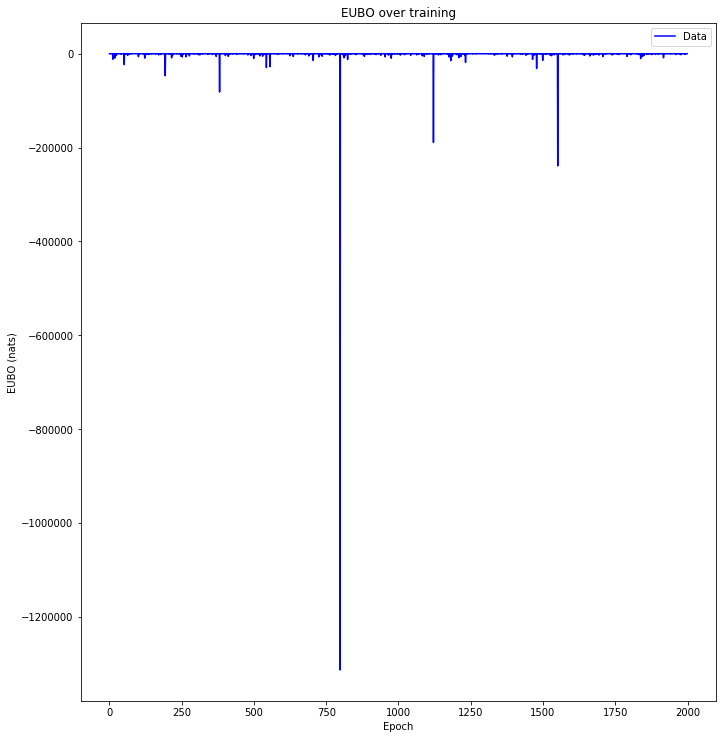

In [20]:
modal_directions = torch.zeros(num_series, K, 2)

for s in range(num_series):
    trajectory, displacements, data = generate_trajectory_trace(s)

    bouncing_ball_smc = generative_model(data, prior_init_params.copy())
    bouncing_ball_proposal = proposal_model(data, variational_init_params.copy())
    importance_sampler = combinators.GuidedConditioning(bouncing_ball_proposal, bouncing_ball_smc)
    
    inference, trained_params, eubos = importance.variational_importance(
        importance_sampler, 2000, data,
        use_cuda=False, lr=1e-1, inclusive_kl=True,
        patience=200,
    )
    utils.plot_evidence_bounds(eubos, False)
    
    bouncing_ball_posterior = posterior_model(data, trained_params, bouncing_ball_proposal.folder.operator)
    (positions, _, A_pred, final_mu, final_cov), inference, _ = bouncing_ball_posterior(data=data)
    As_pred[s] = A_pred.mean(dim=0).detach().numpy()
    final_mus[s] = final_mu.mean(dim=0).detach().numpy()
    final_covs[s] = final_cov.mean(dim=0).detach().numpy()
    inferred_trajectory = accumulate_trajectory(inference)
    
    positions = inferred_trajectory[:, 1:, :].mean(dim=0).cpu().detach()
    displacements = torch.stack([inference['Reduce/Foldable(%d)/BouncingBallStep' % t]['displacement_%d' % (t+1)].value for t in range(T)], dim=0).cpu().detach()
    step_numbers = torch.stack((torch.arange(T), torch.arange(T) + 1), dim=-1)
    velocity_srcs = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements), displacements[:-1]), dim=1)
    velocity_dests = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements) + 1, displacements[1:]), dim=1)
    velocity_steps = torch.stack((velocity_srcs, velocity_dests), dim=1)
    
    graph_position_trajectory(positions, T, s)
    graph_displacement_trajectories(velocity_steps, displacements, T, s)
    
    modal_directions[s] = bouncing_ball.reflect_directions(trained_params['directions']['loc']['loc'].unsqueeze(0)).squeeze(0)
    
    plt.close('all')

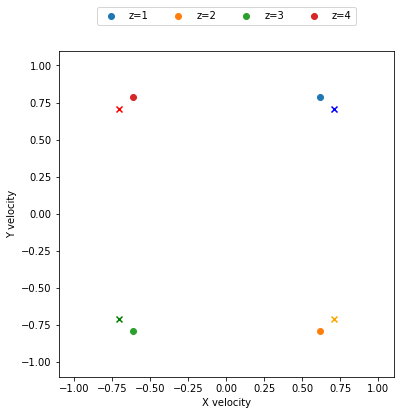

In [21]:
graph_velocity_frequencies(modal_directions.detach())

In [22]:
import bouncing_ball_plots

In [23]:
fs = 3 ## figure size
vmax = 0.3 ## cmap maximum value, to make off-diagonal elements more visible
width_space = 0.05 # space between figures
height_space = 0.05 # space between figures
cov_flag = False # plot the covariances or not
legend_flag = False # plot the legend bar or not
save_flag = True ## save or not

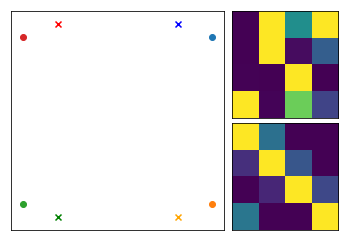

In [24]:
## plot method 1
bouncing_ball_plots.plot_circle_transition(init_v, final_mus, final_covs,
                                           As_pred, As_true, K, fs, vmax, width_space, height_space, cov_flag, legend_flag, save_flag)

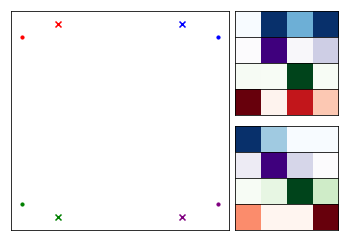

In [25]:
## plot method 2
bouncing_ball_plots.plot_circle_transition_colorcode(init_v, final_mus, final_covs, As_pred, As_true, K, fs, vmax, width_space, height_space, cov_flag, legend_flag, save_flag)

In [26]:
def plot_circle_transition_colorcode(init_v, final_mus, final_covs, As_pred, As_true, K, fs, vmax, width_space, height_space, cov_flag, legend_flag, save_flag):

    As_infer = As_pred / As_pred.sum(-1)[:, :, None]
    As_infer = As_infer.mean(0)
    As_true_ave = As_true.mean(0)

    fig = plt.figure(figsize=(fs*1.5 + width_space,fs + height_space))
    gs1 = gridspec.GridSpec(1, 1)
    # , width_ratios=[2,1], height_ratios=[1,1]
    gs1.update(left=0.0, bottom=0.0, right=(2/3), top=1.0, wspace=width_space, hspace=height_space)
    ax1 = fig.add_subplot(gs1[0])

    # ax3 = fig.add_subplot(gs[1, 1])
    ax1.set_xticks([])
    ax1.set_yticks([])

    gs2 = gridspec.GridSpec(4, 1)
    gs2.update(left=2/3 + (1/3)*width_space, bottom=0.5+(1/2)*width_space, right=1.0, top=1.0, wspace=0, hspace=0)
    ax2 = fig.add_subplot(gs2[0, 0])
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax3 = fig.add_subplot(gs2[1, 0])
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax4 = fig.add_subplot(gs2[2, 0])
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax5 = fig.add_subplot(gs2[3, 0])
    ax5.set_xticks([])
    ax5.set_yticks([])

    gs3 = gridspec.GridSpec(4, 1)
    gs3.update(left=2/3 + (1/3)*width_space, bottom=0.0, right=1.0, top=0.5 - (1/2)*width_space, wspace=0, hspace=0)
    ax6 = fig.add_subplot(gs3[0, 0])
    ax6.set_xticks([])
    ax6.set_yticks([])
    ax7 = fig.add_subplot(gs3[1, 0])
    ax7.set_xticks([])
    ax7.set_yticks([])
    ax8 = fig.add_subplot(gs3[2, 0])
    ax8.set_xticks([])
    ax8.set_yticks([])
    ax9 = fig.add_subplot(gs3[3, 0])
    ax9.set_xticks([])
    ax9.set_yticks([])
    markersize = 10.0
    colors = ['b', 'Purple', 'g', 'r']
    ## plot left one
    ax1.scatter(init_v[:,0], init_v[:,1], s=markersize, color=colors[0], label='z=1')
    ax1.scatter(init_v[:,0], -init_v[:,1], s=markersize, color=colors[1], label='z=2')
    ax1.scatter(-init_v[:,0], -init_v[:,1], s=markersize, color=colors[2], label='z=3')
    ax1.scatter(-init_v[:,0], init_v[:,1], s=markersize, color=colors[3], label='z=4')

    for k in range(K):
        ax1.scatter(final_mus[:,k,0], final_mus[:,k,1], c=colors[k], marker='x')
    if cov_flag:
        for k in range(K):
            for s in range(num_series):
                plot_cov_ellipse(cov=final_covs[s, k, :, :], pos=final_mus[s, k, :], nstd=0.3, ax=ax1, alpha=0.3)
    #    ax1.set_xlabel('x velocity')
    #    ax1.set_ylabel('y velocity')
    if legend_flag:
        ax1.legend(loc='upper center', bbox_to_anchor=(0.75, 1.15), ncol=4)

    ax2.imshow(As_infer[None, 0,:], cmap='Blues', vmin=0, vmax=vmax)
    ax3.imshow(As_infer[None, 1,:], cmap='Purples', vmin=0, vmax=vmax)
    ax4.imshow(As_infer[None, 2,:], cmap='Greens', vmin=0, vmax=vmax)
    ax5.imshow(As_infer[None, 3,:], cmap='Reds', vmin=0, vmax=vmax)

    ax6.imshow(As_true_ave[None, 0,:], cmap='Blues', vmin=0, vmax=vmax)
    ax7.imshow(As_true_ave[None, 1,:], cmap='Purples', vmin=0, vmax=vmax)
    ax8.imshow(As_true_ave[None, 2,:], cmap='Greens', vmin=0, vmax=vmax)
    ax9.imshow(As_true_ave[None, 3,:], cmap='Reds', vmin=0, vmax=vmax)

    if save_flag:
        fig.savefig('combinator_results.pdf', dpi=600, bbox_inches='tight')
        fig.savefig('combinator_results.svg', dpi=600, bbox_inches='tight')
        fig.savefig('combinator_results.png', dpi=600, bbox_inches='tight')

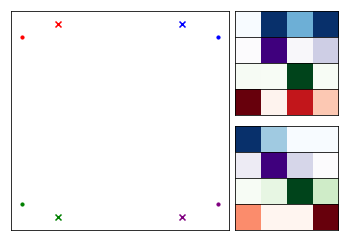

In [27]:
## plot method 2
plot_circle_transition_colorcode(init_v, final_mus, final_covs, As_pred, As_true, K, fs, vmax, width_space, height_space, cov_flag, legend_flag, save_flag)